In [2]:
import requests
import json
import bs4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import re
import time
import itertools
from fantasyAnalytics import extractData as ed
from fantasyAnalytics import loadData as ld

%autoreload 2
%matplotlib inline

## Get Fantasy Data

In [2]:
#vars
column_names = ["week",
                "name",
                "position",
                "team",
                "opponent",
                "pass_yds",
                "pass_td",
                "int",
                "rush_yds",
                "rush_td",
                "rec_yds",
                "rec_td",
                "fum_td",
                "2pt",
                "fum_lost",
                "points"]

<hr>
## Helper Functions

In [28]:
def extract_page_data(page_html, week):
    """
    INPUT: BeautifulSoup, int
    RETURN: list
    
    Returns list of player data with week number
    from an NFL Fantasy player rankings page.
    
    """
    # setup vars
    data = []
    
    
    # iterate over players
    for player in page_html:
        values = [week]
        
        # get name, position, team
        td = player.find("td", class_="playerNameAndInfo")
        name = td.find("a").text
        info = td.find("em").text.split("-")
        
        if len(info) == 2:
            position, team = info[0].strip(), info[1].strip()
        else:
            position, team = info[0].strip(), "NA"
      
        # add name, position, team
        values.append(name)
        values.append(position)
        values.append(team)
        
        # get opponent
        opponent = player.find("td", class_="playerOpponent").text
        values.append(opponent)
        
        # get stats
        for stat in player.findAll("td", class_="stat"):
            value = stat.text.strip()
            values.append(0 if value == "-" else float(value))
        
        data.append(values)
        
    return data

In [ ]:
def save_week_data(week):
    # setup vars
    pages = range(0,40)
    pages_data = []
    url = "http://fantasy.nfl.com/research/scoringleaders?offset={}&position=O&sort=pts&statCategory=stats&statSeason=2016&statType=weekStats&statWeek={}#researchScoringLeaders=researchScoringLeaders%2C%2Fresearch%2Fscoringleaders%253Foffset%253D1%2526position%253DO%2526sort%253Dpts%2526statCategory%253Dstats%2526statSeason%253D2016%2526statType%253DweekStats%2526statWeek%253D1%2Creplace"
    # iterate over pages
    for page in pages:
        # make request
        offset = page * 25 + 1
        response = requests.get(url.format(offset, week))

        # get html
        soup = bs4.BeautifulSoup(response.content, 'html.parser')
        page_html = soup.findAll("tr", class_=re.compile("player"))

        # get data
        page_data = extract_page_data(page_html, week)
        pages_data.append(page_data)
        
        # wait to make next reqeust
        time.sleep(np.random.rand() * 5)
    
    # concatenate pages_data
    week_data = list(itertools.chain.from_iterable(pages_data))
    
    # convert to df
    df_week = pd.DataFrame(week_data, columns=column_names)
    
    # save to file
    df_week.to_pickle("./data/fss_2016_week{}.pkl".format(week))

In [3]:
def get_season_df(start_week, end_week):
    df_season = pd.read_pickle("./data/fss_2016_week{}.pkl".format(start_week))
    weeks = range(start_week+1, end_week+1)
    for week in weeks:
        df_season = df_season.append(pd.read_pickle("./data/fss_2016_week{}.pkl".format(week)))
        
    return df_season

In [3]:
def save_season_data(start_week, end_week):
    # get season data over range from start_week to end_week
    weeks = range(start_week, end_week+1)
    for week in weeks:
        save_week_data(week)

<hr>

## Analysis

In [7]:
# concatenate week data into season data
df_season = ld.get_season_df(1, 9)

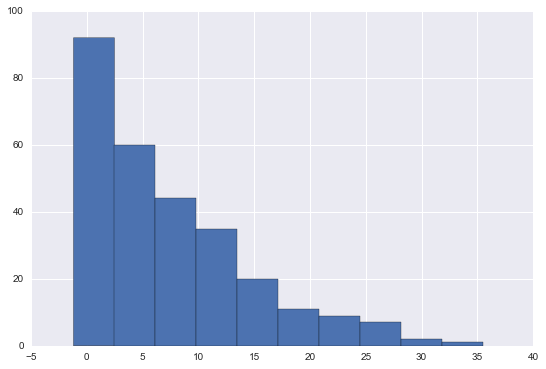

In [7]:
# observe dist of players points for week 1
plt.figure(figsize=(9,6))
df_temp = df_season.points[df_season.week==1]
df_temp = df_temp[df_temp != 0]
plt.hist(df_temp.values, bins=10);

In [ ]:
# observe dist of players points for week 1
plt.figure(figsize=(9,6))
df_temp = df_season.points[df_season.week==1]
df_temp = df_temp[df_temp != 0]
plt.hist(df_temp.values, bins=10);

## Distribution of Players by STDM (STD to Mean)

In [8]:
# filter df to points only
df_temp = df_season[df_season.opponent != "Bye"]
df_temp = df_temp[df_temp != 0]
df_points = df_temp[["name", "position", "points"]].dropna()

In [9]:
# get players that average 7.0 points or more
df_mean = df_points.groupby(["name", "position"]).agg(lambda x: x.mean())
df_temp = (df_mean > 7.0).reset_index().set_index("name")

# remove those that average less
names = df_temp[df_temp.points==True].index.values
df_mean = df_mean.reset_index().set_index("name")
df_mean = df_mean[df_mean.index.isin(names)].rename(columns={"points": "mean"})

df_mean.head()

,position,mean
name,,
A.J. Green,WR,13.450000
Aaron Rodgers,QB,21.897143
Alex Smith,QB,14.088571
Allen Hurns,WR,8.042857
Allen Robinson,WR,7.800000


In [10]:
# get std for players
df_std = df_points[["name", "points"]].groupby("name").agg(lambda x: x.std()).dropna().rename(columns={"points": "std"})

In [11]:
# filter points df to players that average 7.0 points or more
df_std = df_std[df_std.index.isin(names)].dropna()
df_std.head()

,std
name,
A.J. Green,8.607804
Aaron Rodgers,7.241321
Alex Smith,7.866146
Allen Hurns,4.073024
Allen Robinson,5.392588


In [12]:
# get final df
df_stdm = df_mean.join(df_std, how="right")
df_stdm["ratio"] = df_stdm["mean"] / df_stdm["std"]
df_stdm.sort_values("mean", ascending=False, inplace=True)

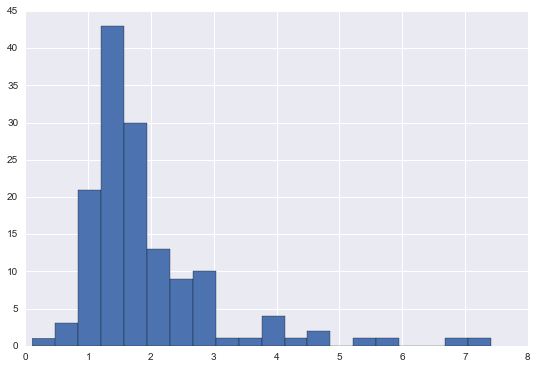

In [188]:
# plot
plt.figure(figsize=(9,6))
plt.hist(df_stdm.ratio.values, bins=20);

### Best Players by Position
#### RB

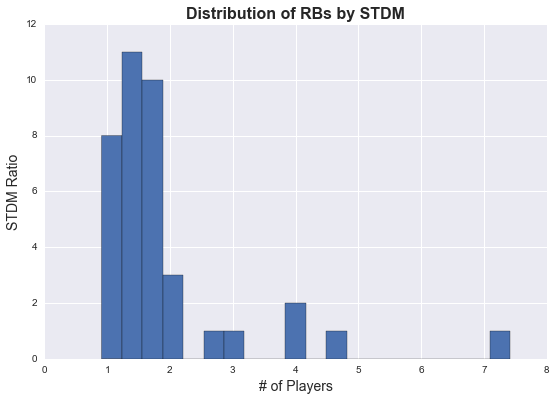

In [189]:
plt.figure(figsize=(9,6))
plt.hist(df_stdm[df_stdm.position=="RB"].ratio.values, bins=20)
plt.xlabel("# of Players", fontsize=14)
plt.ylabel("STDM Ratio", fontsize=14)
plt.title("Distribution of RBs by STDM", fontsize=16, fontweight="semibold");

In [190]:
df_stdm[df_stdm.position=="RB"].head(15)

,position,mean,std,ratio
name,,,,
David Johnson,RB,19.650000,11.054847,1.777501
DeMarco Murray,RB,17.662500,3.934440,4.489203
Ezekiel Elliott,RB,17.557143,6.116333,2.870534
Melvin Gordon,RB,16.887500,6.124293,2.757461
LeSean McCoy,RB,15.928571,10.007117,1.591724
Le'Veon Bell,RB,15.225000,2.053249,7.415076
LeGarrette Blount,RB,14.500000,6.846480,2.117877
Jay Ajayi,RB,14.400000,12.615704,1.141434
Carlos Hyde,RB,14.250000,8.588539,1.659188


### Best WRs By STDM

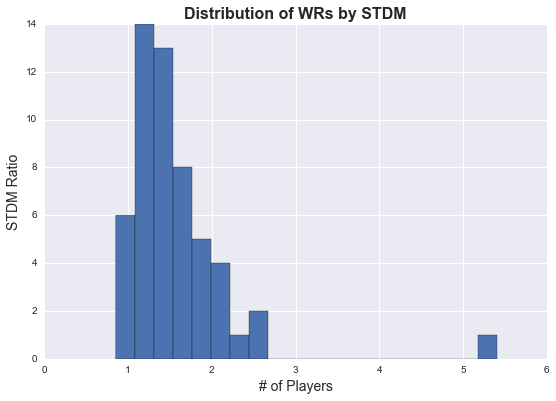

In [263]:
plt.figure(figsize=(9,6))
plt.hist(df_stdm[df_stdm.position=="WR"].ratio.values, bins=20)
plt.xlabel("# of Players", fontsize=14)
plt.ylabel("STDM Ratio", fontsize=14)
plt.title("Distribution of WRs by STDM", fontsize=16, fontweight="semibold");

In [191]:
df_stdm[df_stdm.position=="WR"].head(15)

,position,mean,std,ratio
name,,,,
Corey Coleman,WR,14.650000,10.960155,1.336660
Mike Evans,WR,13.928571,5.842292,2.384093
Julio Jones,WR,13.737500,11.580271,1.186285
A.J. Green,WR,13.450000,8.607804,1.562536
Antonio Brown,WR,13.014286,7.321527,1.777537
Brandin Cooks,WR,12.128571,9.833228,1.233427
T.Y. Hilton,WR,11.862500,8.776419,1.351633
Michael Crabtree,WR,11.862500,7.263596,1.633144
Amari Cooper,WR,11.837500,7.840543,1.509781


### Best TEs by STDM

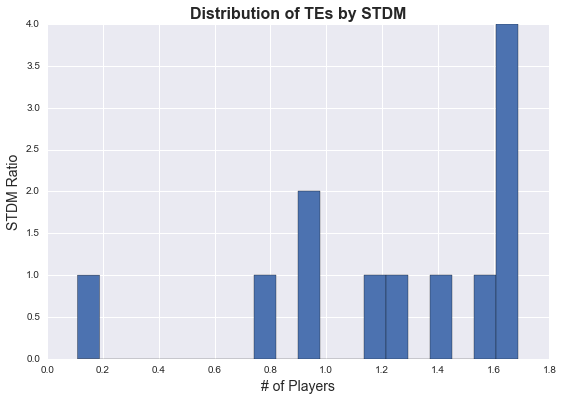

In [265]:
plt.figure(figsize=(9,6))
plt.hist(df_stdm[df_stdm.position=="TE"].ratio.values, bins=20)
plt.xlabel("# of Players", fontsize=14)
plt.ylabel("STDM Ratio", fontsize=14)
plt.title("Distribution of TEs by STDM", fontsize=16, fontweight="semibold");

In [192]:
df_stdm[df_stdm.position=="TE"].head(10)

,position,mean,std,ratio
name,,,,
Rob Gronkowski,TE,13.280000,7.917828,1.677228
Greg Olsen,TE,10.871429,6.566510,1.655587
Jordan Reed,TE,9.916667,6.077308,1.631753
Tyler Eifert,TE,8.550000,10.818734,0.790296
Delanie Walker,TE,8.400000,5.340724,1.572820
Martellus Bennett,TE,8.100000,8.838552,0.916440
Travis Kelce,TE,7.957143,5.615709,1.416944
Kyle Rudolph,TE,7.171429,4.250770,1.687089
Zach Miller,TE,7.162500,5.818428,1.231003


### Best QBs by STDM

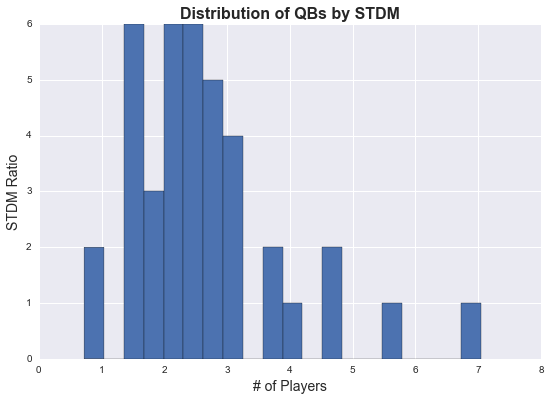

In [267]:
plt.figure(figsize=(9,6))
plt.hist(df_stdm[df_stdm.position=="QB"].ratio.values, bins=20)
plt.xlabel("# of Players", fontsize=14)
plt.ylabel("STDM Ratio", fontsize=14)
plt.title("Distribution of QBs by STDM", fontsize=16, fontweight="semibold");

In [193]:
df_stdm[df_stdm.position=="QB"].head(15)

,position,mean,std,ratio
name,,,,
Tom Brady,QB,26.290000,5.550171,4.736791
Drew Brees,QB,23.105714,7.908845,2.921503
Matt Ryan,QB,22.792500,7.027562,3.243301
Aaron Rodgers,QB,21.897143,7.241321,3.023916
Andrew Luck,QB,21.032500,8.116917,2.591193
Derek Carr,QB,20.367500,8.664218,2.350760
Ben Roethlisberger,QB,20.200000,10.577538,1.909707
Cam Newton,QB,19.903333,7.291325,2.729728
Matthew Stafford,QB,19.345000,7.064517,2.738333


## Defense Effects

We want to find the effect each defense has on WRs and RBs, relative to the average effectiveness of WRs and RBs. This means finding the average score of WRs and RBs against each defense and evaluating the difference between those scores and the average score.

It might be good to break it down by position more for WR1's - this would give a good indication of how good a defense's top cornerback coverage is.

### Effect of each Defense on WRs

### Get WR against Defenses

In [237]:
defenses_against("WR").sort_values("mean")

,team,points_against,mean,std
29,DEN,85.70,10.712500,5.876451
11,MIN,99.10,14.157143,3.334595
30,HOU,133.70,16.712500,8.701303
10,PIT,123.70,17.671429,7.877122
31,ARI,160.40,20.050000,7.070664
23,IND,166.40,20.800000,8.340264
1,NE,166.70,20.837500,8.087722
25,PHI,146.20,20.885714,4.668129
9,CIN,169.50,21.187500,10.732120
26,SEA,148.40,21.200000,10.481094


### Get RB against defenses

In [238]:
defenses_against("RB").sort_values("mean")

,team,points_against,mean,std
7,GB,90.0,12.857143,6.137550
20,DAL,95.1,13.585714,3.611292
9,CHI,109.7,13.712500,8.619652
28,ARI,110.5,13.812500,7.981127
16,BAL,96.9,13.842857,9.162761
25,SEA,97.8,13.971429,6.343426
26,TEN,116.6,14.575000,5.612168
0,CAR,102.3,14.614286,9.324596
13,DET,123.4,15.425000,3.596725
14,MIA,108.8,15.542857,3.841379


### Get TE against defenses

In [239]:
defenses_against("TE").sort_values("mean")

,team,points_against,mean,std
29,ARI,18.2,2.600000,1.915724
23,BAL,25.2,4.200000,1.499333
18,JAX,33.4,4.771429,3.228371
30,HOU,35.6,5.085714,5.480398
14,CHI,40.8,5.100000,4.050397
27,KC,33.8,5.633333,3.445964
5,NYG,39.7,5.671429,3.919913
4,LA,40.0,5.714286,6.155331
20,SEA,34.5,5.750000,4.802395
10,NE,46.4,5.800000,3.365370


### Test